In [ ]:
#Imports and get session data in

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates

Talk about why we're importing basic libs, refresher from first webinar 

In [ ]:
from scipy.signal import find_peaks
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

talk about importing more complex libraries, importing functions from libaries (cause they're huge!) 

In [6]:
pd.options.mode.chained_assignment = None  # default='warn'
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

df = pd.read_csv('session-data.csv', parse_dates=['t'])
df = df.set_index('t')
df.head()

,x,y,z,classification,ax,ay,az,jx,jy,jz,j,jvar
t,,,,,,,,,,,,
2015-07-22 09:04:36.011718,872.0,-16732.0,-1248.0,2,0.048444,-0.929556,-0.069333,NaN,NaN,NaN,NaN,NaN
2015-07-22 09:04:36.080684,860.0,-16856.0,-1176.0,2,0.047778,-0.936444,-0.065333,-0.000667,-0.006889,0.004000,0.007994,NaN
2015-07-22 09:04:36.149650,808.0,-16824.0,-1256.0,2,0.044889,-0.934667,-0.069778,-0.002889,0.001778,-0.004444,0.005591,NaN
2015-07-22 09:04:36.218616,776.0,-16748.0,-1256.0,2,0.043111,-0.930444,-0.069778,-0.001778,0.004222,0.000000,0.004581,NaN
2015-07-22 09:04:36.287582,876.0,-16788.0,-1172.0,2,0.048667,-0.932667,-0.065111,0.005556,-0.002222,0.004667,0.007588,NaN


First lines of code are working around errors which come up. Loading in and presenting dataset.

Code all Open Source, relying on other people's work and documentation.

In [9]:
# set plot params

date_fmt = mdates.DateFormatter('%H:%M')
mpl.rcParams['figure.figsize'] = (12,5)
lf=10
tf=14
sf=10

start = "2015-07-23 12:20:00"
end = "2015-07-23 12:50:00"

Setting formats for visualisation and bounds for time series data. Looking at accel data over a half hour period.

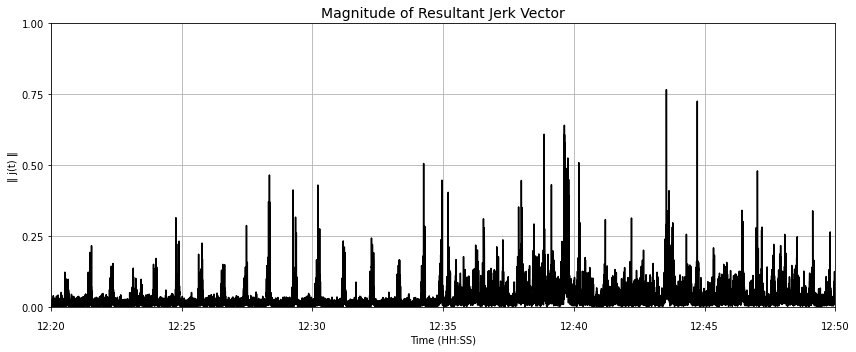

In [20]:
# resolved jerk

mpl.rcParams['figure.figsize'] = (12,5)
p1 = plt.subplot(111)
p1.plot(df[start:end].index, df[start:end]['j'], color='k')
p1.set_ylabel('‖ j(t) ‖', fontsize=lf)
p1.set_xlabel('Time (HH:SS)', fontsize=lf)
p1.set_title('Magnitude of Resultant Jerk Vector', fontsize=tf)
p1.set_xlim([start,end])
p1.set_yticks(np.arange(0, 1.5, step=0.25))
p1.set_ylim([0, 1])
p1.tick_params(axis = 'both', which = 'major', labelsize = sf)
p1.tick_params(axis='x', pad=10)
p1.grid()

for ax in [p1]:
    ax.xaxis.set_major_formatter(date_fmt)    
plt.tight_layout()

Manufacturing acceleration data - pause to talk about data pre-processing. Understand signal and noise in the data, appropriate window to look at time series data when considering signal evolution over time. How long does a feature/anomaly manifest for in your data? Discuss importance of the quality of data for ML functions. Get out what you put in. Need for domain expertise in interrogating data.


Characterisitics of the dataset are periodicity and variance. Highly periodic and uniform variance. Second part is poorer periodicity, and variance is more volatile. Filter data based on this to highlight features

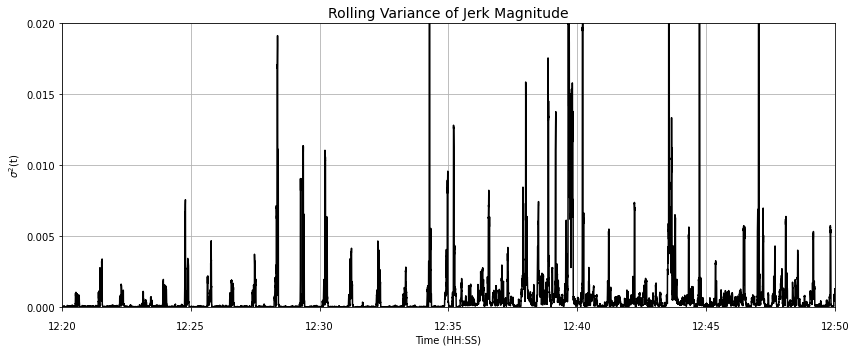

In [19]:
# evaluate jerk rolling variance

def eval_jerk_rolling_var(df, rolling_window):
    df['jvar'] = df['j'].rolling(rolling_window).var()
    return df

w = 19 # 1.5 second duration
df = eval_jerk_rolling_var(df, w)

mpl.rcParams['figure.figsize'] = (12,5)
p1 = plt.subplot(111)
p1.plot(df[start:end].index, df[start:end]['jvar'], color='k')
p1.set_ylabel('$σ^2$(t)', fontsize=lf)
p1.set_xlabel('Time (HH:SS)', fontsize=lf)
p1.set_title('Rolling Variance of Jerk Magnitude', fontsize=tf)
p1.set_xlim([start,end])
p1.set_yticks(np.arange(0, 0.025, step=0.005))
p1.set_ylim([0, 0.02])
p1.tick_params(axis = 'both', which = 'major', labelsize = sf)
p1.tick_params(axis='x', pad=10)
p1.grid()

for ax in [p1]:
    ax.xaxis.set_major_formatter(date_fmt)    
plt.tight_layout()

Results of filtering have been sucessful - this stage can be HIGHLY itterative, effectively a binary classifier on variance. This can take weeks of work and requires domain expertise.


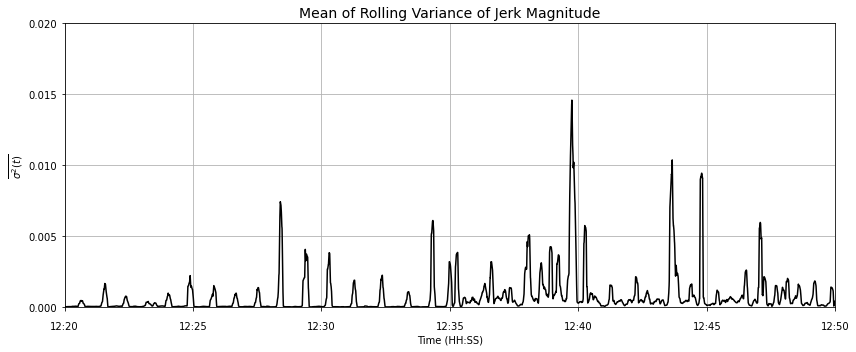

In [10]:
# evaluate rolling mean jerk variance

def eval_rolling_mean_jerk_var(df, wprime):
    df['jvar_mean'] = df['jvar'].rolling(wprime).mean()
    return df

wprime = 100 # 8 seconds
df = eval_rolling_mean_jerk_var(df, wprime)

mpl.rcParams['figure.figsize'] = (12,5)
p1 = plt.subplot(111)
p1.plot(df[start:end].index, df[start:end]['jvar_mean'], color='k')
p1.set_ylabel('$\overline{\sigma^2(t)}$', fontsize=lf)
p1.set_xlabel('Time (HH:SS)', fontsize=lf)
p1.set_title('Mean of Rolling Variance of Jerk Magnitude', fontsize=tf)
p1.set_xlim([start,end])
p1.set_yticks(np.arange(0, 0.025, step=0.005))
p1.set_ylim([0, 0.02])
p1.tick_params(axis = 'both', which = 'major', labelsize = sf)
p1.tick_params(axis='x', pad=10)
p1.grid()

for ax in [p1]:
    ax.xaxis.set_major_formatter(date_fmt)    
plt.tight_layout()

Second filtering to separate the peaks in the previous graph from the underlying signal - isolate the filtered data from the rest. Again part of the iterative data science stage. Preserving the relative distances for periodicity and variance targets.

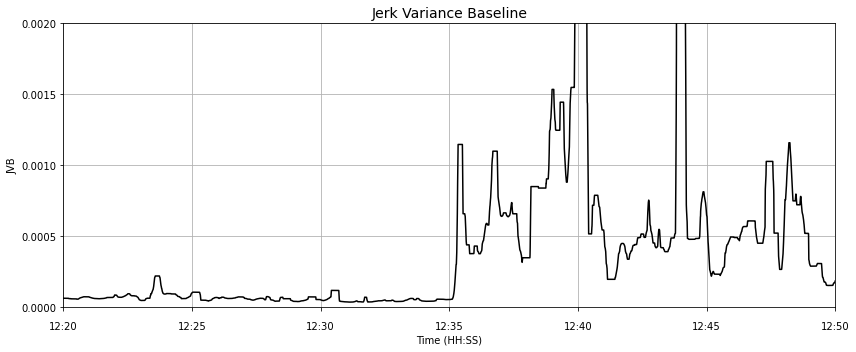

In [11]:
# evaluate jerk variance baseline energy

def eval_jvar_mean_baseline(df, wprimeprime):
    df['jvar_mean_baseline'] = df['jvar_mean'].rolling(wprimeprime).median()
    return df

wprimeprime = 500 # 40 seconds
df = eval_jvar_mean_baseline(df, wprimeprime)

mpl.rcParams['figure.figsize'] = (12,5)
p1 = plt.subplot(111)
p1.plot(df[start:end].index, df[start:end]['jvar_mean_baseline'], color='k')
p1.set_ylabel('JVB', fontsize=lf)
p1.set_xlabel('Time (HH:SS)', fontsize=lf)
p1.set_title('Jerk Variance Baseline', fontsize=tf)
p1.set_xlim([start,end])
p1.set_yticks(np.arange(0, 0.0025, step=0.0005))
p1.set_ylim([0, 0.002])
p1.tick_params(axis = 'both', which = 'major', labelsize = sf)
p1.tick_params(axis='x', pad=10)
p1.grid()

for ax in [p1]:
    ax.xaxis.set_major_formatter(date_fmt) 
plt.tight_layout()

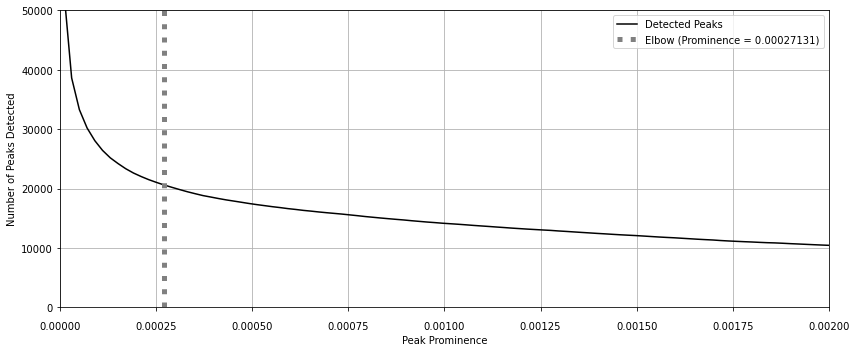

In [12]:
# test the prominence sensitivity to select a single prominence value

min_peak_interval = 1 # when finding peaks, this sets the minimum distance between detecting peaks
npeaks=[]
start_prom = 0.00001
stop_prom =  0.00200
step_prom = 100

steps = np.linspace(start_prom, stop_prom, step_prom)
for n in steps:
    peaks, properties = find_peaks(df['jvar_mean'], prominence=(n), distance=min_peak_interval)
    npeaks.append(len(peaks))

xvals = (steps[0], steps[-1])
yvals = (npeaks[0], npeaks[-1])
m = (yvals[1]-yvals[0])/(xvals[1]-xvals[0])
c = yvals[1]-(m*xvals[1])
ylin = (steps*m)+c
ydiff = ylin-npeaks
maxydiff = max(ydiff)
maxyx = steps[np.where(ydiff == maxydiff)]

mpl.rcParams['figure.figsize'] = (12,5)
p1 = plt.subplot(111)
p1.set_ylabel('Number of Peaks Detected', fontsize=lf)
p1.set_xlabel('Peak Prominence', fontsize=lf)
p1.plot(steps, npeaks, color='black')
p1.axvline(x=maxyx, linestyle = ':', linewidth = 5, color='gray')
p1.set_xlim([0,stop_prom])
p1.set_ylim([0,50000])
p1.tick_params(axis = 'both', which = 'major', labelsize = sf)
p1.tick_params(axis='x', pad=10)
p1.legend(['Detected Peaks','Elbow (Prominence = {:.5})'.format(float(maxyx))], fontsize=lf)
p1.grid()

plt.tight_layout()

Talk here about features we need for determining thresholds. Look for elbow points in graph to optimise - tradeoff in complexity and computation.

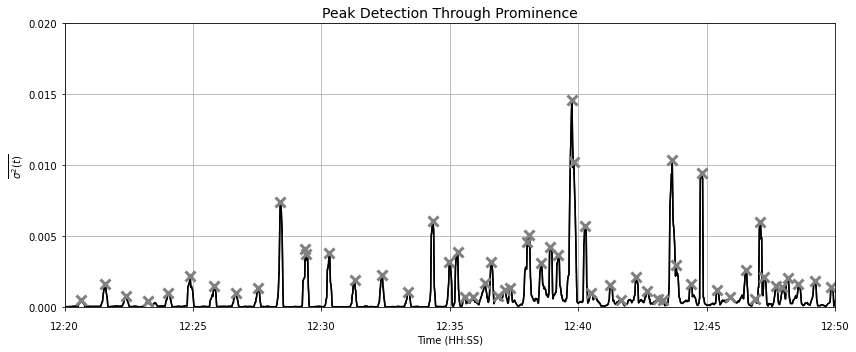

In [13]:
# evaluate peak properties based on prominence sensitivity (prom value and mi_peak_interval value)

def eval_peaks_properties(df, prom, dist):
    peaks, properties = find_peaks(df['jvar_mean'], prominence=prom, distance=dist)
    df_peaks = df.iloc[peaks]
    return df_peaks

prominence = float(maxyx) # based on above graph
min_peak_interval = 1 # based on above graph
df_peaks = eval_peaks_properties(df, prominence, min_peak_interval)

# convert collar classification to rumination or eating/other (1, 0)

def convert_col_binary(df_peaks):
    df_peaks.classification[df_peaks.classification==2]=0
    df_peaks.classification = df_peaks.classification.astype(float)
    return df_peaks

df_peaks = convert_col_binary(df_peaks)

# evaluate inter-contraction interval

def eval_ici(df_peaks):
    ici = df_peaks.index.to_frame().t.diff().apply(lambda k: k.seconds)
    df_peaks = df_peaks.assign(ici = ici)
    return df_peaks

df_peaks = eval_ici(df_peaks)

mpl.rcParams['figure.figsize'] = (12,5)
p1 = plt.subplot(111)
p1.plot(df[start:end].index, df[start:end]['jvar_mean'], color='k')
p1.set_ylabel('$\overline{\sigma^2(t)}$', fontsize=lf)
p1.set_xlabel('Time (HH:SS)', fontsize=lf)
p1.set_title('Peak Detection Through Prominence', fontsize=tf)
p1.plot(df[start:end].index, df[start:end]['jvar_mean'], color='black')
p1.plot(df_peaks[start:end].index, df_peaks[start:end]['jvar_mean'], "x", markersize=10, markeredgewidth=3, color='gray')
p1.set_xlim([start,end])
p1.set_yticks(np.arange(0, 0.025, step=0.005))
p1.set_ylim([0, 0.02])
p1.tick_params(axis = 'both', which = 'major', labelsize = sf)
p1.tick_params(axis='x', pad=10)
p1.grid()

for ax in [p1]:
    ax.xaxis.set_major_formatter(date_fmt)    
plt.tight_layout()

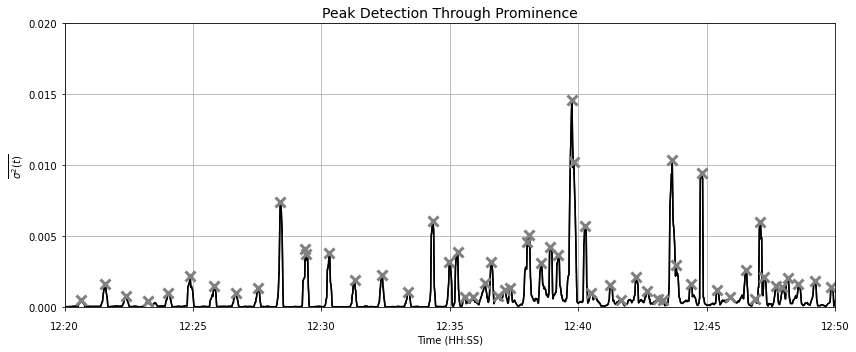

In [14]:
# evaluate peak properties based on prominence sensitivity (prom value and mi_peak_interval value)

def eval_peaks_properties(df, prom, dist):
    peaks, properties = find_peaks(df['jvar_mean'], prominence=prom, distance=dist)
    df_peaks = df.iloc[peaks]
    return df_peaks

prominence = float(maxyx) # based on above graph
min_peak_interval = 1 # based on above graph
df_peaks = eval_peaks_properties(df, prominence, min_peak_interval)

# convert collar classification to rumination or eating/other (1, 0)

def convert_col_binary(df_peaks):
    df_peaks.classification[df_peaks.classification==2]=0
    df_peaks.classification = df_peaks.classification.astype(float)
    return df_peaks

df_peaks = convert_col_binary(df_peaks)

# evaluate inter-contraction interval

def eval_ici(df_peaks):
    ici = df_peaks.index.to_frame().t.diff().apply(lambda k: k.seconds)
    df_peaks = df_peaks.assign(ici = ici)
    return df_peaks

df_peaks = eval_ici(df_peaks)

mpl.rcParams['figure.figsize'] = (12,5)
p1 = plt.subplot(111)
p1.plot(df[start:end].index, df[start:end]['jvar_mean'], color='k')
p1.set_ylabel('$\overline{\sigma^2(t)}$', fontsize=lf)
p1.set_xlabel('Time (HH:SS)', fontsize=lf)
p1.set_title('Peak Detection Through Prominence', fontsize=tf)
p1.plot(df[start:end].index, df[start:end]['jvar_mean'], color='black')
p1.plot(df_peaks[start:end].index, df_peaks[start:end]['jvar_mean'], "x", markersize=10, markeredgewidth=3, color='gray')
p1.set_xlim([start,end])
p1.set_yticks(np.arange(0, 0.025, step=0.005))
p1.set_ylim([0, 0.02])
p1.tick_params(axis = 'both', which = 'major', labelsize = sf)
p1.tick_params(axis='x', pad=10)
p1.grid()

for ax in [p1]:
    ax.xaxis.set_major_formatter(date_fmt)    
plt.tight_layout()

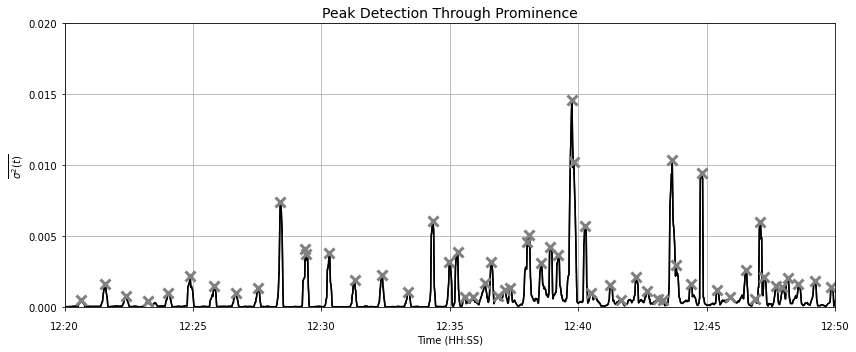

In [15]:
# evaluate peak properties based on prominence sensitivity (prom value and mi_peak_interval value)

def eval_peaks_properties(df, prom, dist):
    peaks, properties = find_peaks(df['jvar_mean'], prominence=prom, distance=dist)
    df_peaks = df.iloc[peaks]
    return df_peaks

prominence = float(maxyx) # based on above graph
min_peak_interval = 1 # based on above graph
df_peaks = eval_peaks_properties(df, prominence, min_peak_interval)

# convert collar classification to rumination or eating/other (1, 0)

def convert_col_binary(df_peaks):
    df_peaks.classification[df_peaks.classification==2]=0
    df_peaks.classification = df_peaks.classification.astype(float)
    return df_peaks

df_peaks = convert_col_binary(df_peaks)

# evaluate inter-contraction interval

def eval_ici(df_peaks):
    ici = df_peaks.index.to_frame().t.diff().apply(lambda k: k.seconds)
    df_peaks = df_peaks.assign(ici = ici)
    return df_peaks

df_peaks = eval_ici(df_peaks)

mpl.rcParams['figure.figsize'] = (12,5)
p1 = plt.subplot(111)
p1.plot(df[start:end].index, df[start:end]['jvar_mean'], color='k')
p1.set_ylabel('$\overline{\sigma^2(t)}$', fontsize=lf)
p1.set_xlabel('Time (HH:SS)', fontsize=lf)
p1.set_title('Peak Detection Through Prominence', fontsize=tf)
p1.plot(df[start:end].index, df[start:end]['jvar_mean'], color='black')
p1.plot(df_peaks[start:end].index, df_peaks[start:end]['jvar_mean'], "x", markersize=10, markeredgewidth=3, color='gray')
p1.set_xlim([start,end])
p1.set_yticks(np.arange(0, 0.025, step=0.005))
p1.set_ylim([0, 0.02])
p1.tick_params(axis = 'both', which = 'major', labelsize = sf)
p1.tick_params(axis='x', pad=10)
p1.grid()

for ax in [p1]:
    ax.xaxis.set_major_formatter(date_fmt)    
plt.tight_layout()

NameError: name 'ici_thres' is not defined

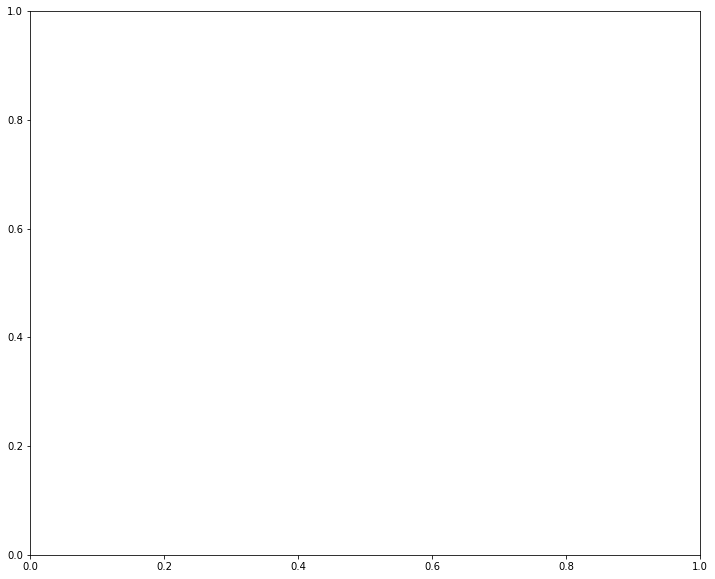

In [16]:
# plot with true states from collar

mpl.rcParams['figure.figsize'] = (12,10)
p1 = plt.subplot(111)
xlims = [0,ici_thres]
ylims = [-12,-2]
s = 2

p1.scatter(scat_data[:,0], scat_data[:,1], c=scat_data[:,2], cmap = 'bwr', s=s)
p1.set_xlim(xlims)
p1.set_ylim(ylims)
p1.set_title("$\overline{JVB}$ vs. $\overline{ICI}$ - Binary Collar Classifier", fontsize=tf)
p1.set_xlabel('$\overline{ICI}$ (s)', fontsize=lf)
p1.set_ylabel('log($\overline{JVB}$)', fontsize=lf)
p1.tick_params(axis = 'both', which = 'major', labelsize = sf)
p1.grid()

plt.tight_layout()

In [ ]:
# split into training and test groups and also return X and Y values

def split_test_train(scat_data, test_size):
    X = scat_data[:,[0,1]]# split data set into attributes and labels
    y = scat_data[:,2].astype(np.integer) # convert the state (0,1) to integer for SVM
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, stratify=y)
    return X_train, X_test, y_train, y_test, X, y

def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    return TP, FP, TN, FN

X_train, X_test, y_train, y_test, X, y = split_test_train(scat_data, 0.2)

# classify data using training set

svclassifier = SVC(kernel='linear', degree=2, class_weight='balanced') # train algorithm (note degree is ignored by algorithms except 'poly')
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test) # make predictions
score = svclassifier.score(X_test, y_test) # get score of classifier using remaining test data
class_report = classification_report(y_test,y_pred, output_dict=True) # extract f1 scores
f1 = class_report['weighted avg']['f1-score']

# get TP etc...

TP, FP, TN, FN = perf_measure(y_test, y_pred)

# get linear svm coeffs for plotting decision line

coeffs = svclassifier.coef_[0]
m = -coeffs[0]/coeffs[1]
c = -(svclassifier.intercept_[0])/coeffs[1]
xx = np.linspace(0, ici_thres)
yy = (m*xx)+c

mpl.rcParams['figure.figsize'] = (12,10)
pxy = np.column_stack((X,y))
pp0 = pxy[pxy[:,2]==0]
pp1 = pxy[pxy[:,2]==1]

p1 = plt.subplot(111)
xlims = [0,ici_thres]
ylims = [-12,-2]
s = 2
p1.scatter(X[:,0], X[:,1], c=y, cmap = 'bwr', s=s)
p1.plot(xx, yy, color='black', linestyle='--')
p1.set_xlim(xlims)
p1.set_ylim(ylims)
p1.set_title("F1 Score: {:.3f}".format(0.861), fontsize=tf)
p1.set_xlabel('$\overline{ICI}$ (s)', fontsize=lf)
p1.set_ylabel('log($\overline{JVB}$)', fontsize=lf)
p1.tick_params(axis = 'both', which = 'major', labelsize = sf)
p1.grid()

plt.tight_layout()